In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# 1. LOAD AND PREPROCESS DATA
data = pd.read_csv("E:\\SEM-2\\AI&ML\\chicagao excel dataset reduced 1.csv")

columns_to_drop = [
    'ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Description',
    'Updated On', 'Location', 'X Coordinate', 'Y Coordinate'
]
data = data.drop(columns=columns_to_drop, errors='ignore')
data = data.fillna(data.mode().iloc[0])

# OUTLIER REMOVAL BASED ON RAW LAT/LON (Chicago bounds)
lat_min, lat_max = 41.6, 42.1
lon_min, lon_max = -87.9, -87.5
if 'Latitude' in data.columns and 'Longitude' in data.columns:
    mask = (
        (data['Latitude'] >= lat_min) & (data['Latitude'] <= lat_max) &
        (data['Longitude'] >= lon_min) & (data['Longitude'] <= lon_max)
    )
    data = data[mask].copy()

# Save raw coordinates for plotting
data['Latitude_raw'] = data['Latitude']
data['Longitude_raw'] = data['Longitude']

# One-hot encode categoricals
categorical_cols = ['Primary Type', 'Location Description']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Convert binary columns
for col in ['Arrest', 'Domestic']:
    if col in data.columns:
        data[col] = data[col].astype(int)

# Scale numeric columns
numeric_cols = ['Beat', 'District', 'Ward', 'Community Area', 'Year', 'Latitude', 'Longitude']
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

# Numeric-only DataFrame for PCA and clustering
df_numeric = data.select_dtypes(include=[np.number]).fillna(data.mean(numeric_only=True))

print("Preprocessing complete and outliers removed.")



Preprocessing complete and outliers removed.


In [2]:
# 2. PCA FOR DIMENSIONALITY REDUCTION (before clustering)
n_pca_components = 5
pca = PCA(n_components=n_pca_components)
df_pca = pca.fit_transform(df_numeric)
print("Explained variance ratio (PCA):", pca.explained_variance_ratio_)
print("Total explained variance by first", n_pca_components, "components:", np.sum(pca.explained_variance_ratio_))

# 3. PREPARE SAMPLE FOR PARAMETER SEARCH
sample_size = 15000
if len(df_pca) > sample_size:
    idx = np.random.choice(len(df_pca), sample_size, replace=False)
    X_sample = df_pca[idx]
    data_sample = data.iloc[idx].copy()
else:
    X_sample = df_pca.copy()
    data_sample = data.copy()

# 4. PARAMETER GRID SEARCH FOR DBSCAN ON PCA DATA
eps_values = [0.5, 1.0, 1.5]
min_samples_values = [10, 20, 50]
print("eps\tmin_samples\tclusters\tnoise_pts\tavg_cluster_size\tSilhouette")
results = []
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        db_labels = dbscan.fit_predict(X_sample)
        n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
        n_noise = list(db_labels).count(-1)
        cluster_sizes = [list(db_labels).count(i) for i in set(db_labels) if i != -1]
        avg_cluster_size = np.mean(cluster_sizes) if cluster_sizes else 0
        # Silhouette (if >1 cluster and not all noise)
        if n_clusters > 1 and np.sum(db_labels != -1) > 1:
            mask = db_labels != -1
            sil = silhouette_score(X_sample[mask], db_labels[mask])
        else:
            sil = float('nan')
        print(f"{eps}\t{min_samples}\t\t{n_clusters}\t\t{n_noise}\t\t{avg_cluster_size:.1f}\t\t{sil:.3f}")
        results.append((eps, min_samples, n_clusters, n_noise, avg_cluster_size, sil, db_labels))

# 5. CHOOSE BEST PARAMETERS
best_eps = 1.0
best_min_samples = 10

# 6. FINAL DBSCAN FIT ON SAMPLE
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
db_labels = dbscan.fit_predict(X_sample)
data_sample['DBSCAN_Cluster'] = db_labels

# Silhouette score (excluding noise) for sample
mask = db_labels != -1
if np.sum(mask) > 1 and len(set(db_labels[mask])) > 1:
    dbscan_sil = silhouette_score(X_sample[mask], db_labels[mask])
    print(f"DBSCAN Silhouette Score (sample, excluding noise): {dbscan_sil:.4f}")
else:
    print("DBSCAN: Not enough clusters for silhouette score.")



Explained variance ratio (PCA): [0.54831944 0.13875918 0.11128158 0.07999807 0.05308164]
Total explained variance by first 5 components: 0.9314399274960985
eps	min_samples	clusters	noise_pts	avg_cluster_size	Silhouette
0.5	10		48		120		310.0		0.094
0.5	20		43		286		342.2		0.301
0.5	50		35		691		408.8		0.415
1.0	10		11		3		1363.4		-0.046
1.0	20		10		13		1498.7		-0.046
1.0	50		8		69		1866.4		-0.034
1.5	10		4		0		3750.0		0.090
1.5	20		4		0		3750.0		0.090
1.5	50		3		43		4985.7		0.091
DBSCAN Silhouette Score (sample, excluding noise): -0.0465


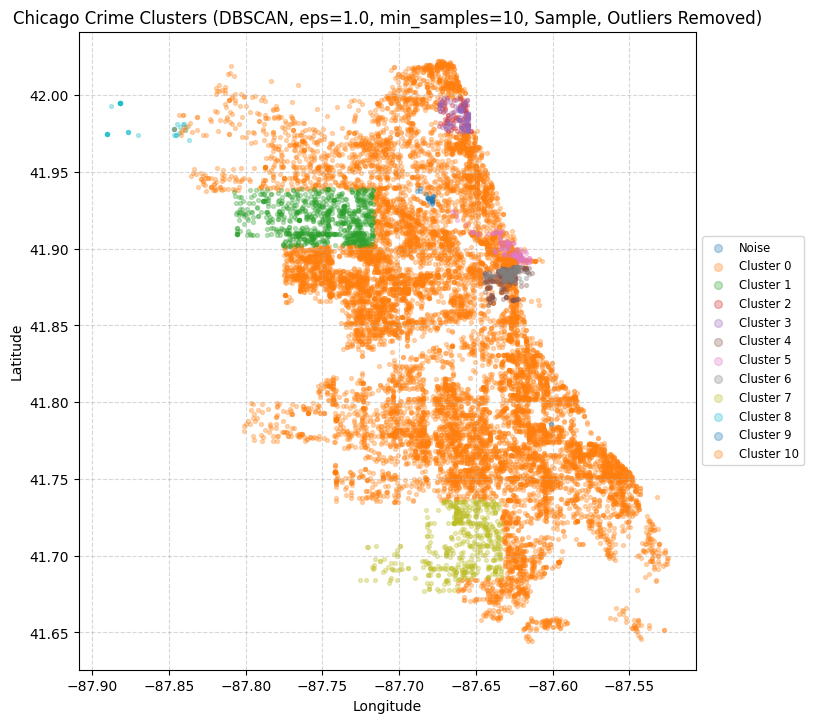

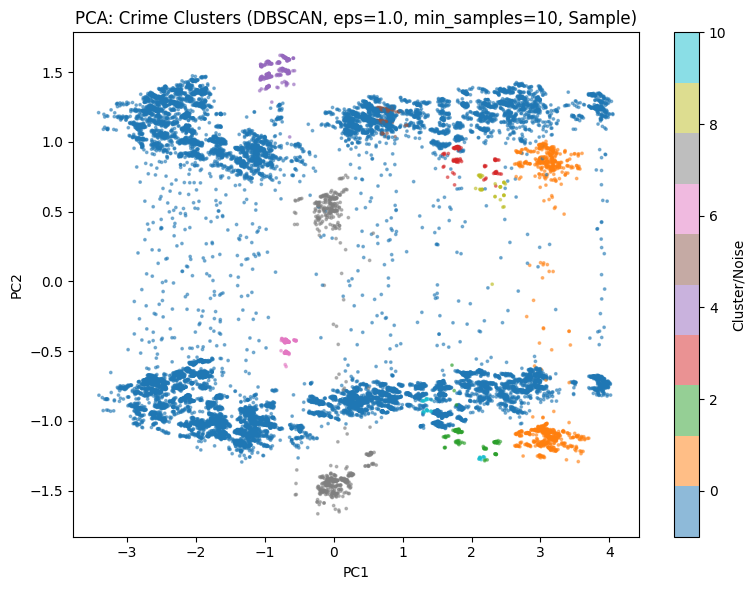

In [3]:
# 7. MAP VISUALIZATION (SAMPLE, using raw coordinates)
plt.figure(figsize=(8, 8))
ax = plt.gca()
for k in sorted(data_sample['DBSCAN_Cluster'].unique()):
    subset = data_sample[data_sample['DBSCAN_Cluster'] == k]
    label = f"Cluster {k}" if k != -1 else "Noise"
    plt.scatter(subset['Longitude_raw'], subset['Latitude_raw'], label=label, alpha=0.3, s=8)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f"Chicago Crime Clusters (DBSCAN, eps={best_eps}, min_samples={best_min_samples}, Sample, Outliers Removed)")
plt.grid(True, linestyle='--', alpha=0.5)
ax.set_aspect('equal', adjustable='box')
plt.legend(markerscale=2, fontsize='small', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# 8. PCA VISUALIZATION (SAMPLE)
pca2 = PCA(n_components=2)
pca_components = pca2.fit_transform(X_sample)
plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:,0], pca_components[:,1], c=db_labels, cmap='tab10', alpha=0.5, s=3)
plt.title(f"PCA: Crime Clusters (DBSCAN, eps={best_eps}, min_samples={best_min_samples}, Sample)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster/Noise')
plt.tight_layout()
plt.show()




In [4]:
# 9. CLUSTER PROFILING (SAMPLE)
def cluster_insight_table(data_sample, cluster_col='DBSCAN_Cluster'):
    # Get cluster sizes
    cluster_sizes = data_sample[cluster_col].value_counts().sort_index()
    # Get arrest rates
    arrest_rates = data_sample.groupby(cluster_col)['Arrest'].mean()
    # Get domestic rates
    domestic_rates = data_sample.groupby(cluster_col)['Domestic'].mean()
    # Most common crime type (if present)
    if 'Primary Type' in data_sample.columns:
        top_crime = data_sample.groupby(cluster_col)['Primary Type'].agg(lambda x: x.value_counts().index[0])
    else:
        top_crime = pd.Series('-', index=cluster_sizes.index)
    # Build summary DataFrame
    summary = pd.DataFrame({
        'Size': cluster_sizes,
        'Arrest Rate': arrest_rates,
        'Domestic Rate': domestic_rates,
        'Top Crime Type': top_crime
    })

    def make_insight(row):
        if row.name == -1:
            return "Noise/outliers: higher arrest & domestic rates, likely atypical incidents"
        elif row['Size'] < 10:
            return "Tiny cluster: may be rare or special-case events"
        elif row['Arrest Rate'] > 0.8:
            return "Very high arrest rate"
        elif row['Arrest Rate'] < 0.05:
            return "Very low arrest rate"
        elif row['Domestic Rate'] > 0.7:
            return "Mostly domestic incidents"
        elif row['Domestic Rate'] < 0.05:
            return "Rarely domestic incidents"
        else:
            return "Typical cluster"
    summary['Insight'] = summary.apply(make_insight, axis=1)
    return summary

table = cluster_insight_table(data_sample, cluster_col='DBSCAN_Cluster')
print(table)

for k in sorted(set(db_labels)):
    print(f"\n--- DBSCAN Cluster {k} ---")
    if 'Primary Type' in data_sample.columns:
        print(data_sample[data_sample['DBSCAN_Cluster'] == k]['Primary Type'].value_counts().head(5))
    print("Arrest Rate:", data_sample[data_sample['DBSCAN_Cluster'] == k]['Arrest'].mean())


                 Size  Arrest Rate  Domestic Rate Top Crime Type  \
DBSCAN_Cluster                                                     
-1                 35     0.371429       0.171429              -   
 0              13260     0.216893       0.178733              -   
 1                480     0.197917       0.210417              -   
 2                795     0.221384       0.184906              -   
 3                102     0.176471       0.147059              -   
 4                109     0.091743       0.055046              -   
 5                 21     0.095238       0.047619              -   
 6                118     0.305085       0.059322              -   
 7                 80     0.275000       0.125000              -   

                                                          Insight  
DBSCAN_Cluster                                                     
-1              Noise/outliers: higher arrest & domestic rates...  
 0                                             

In [ ]:
# 10. FIT DBSCAN ON FULL DATASET (PCA) AND CALCULATE SILHOUETTE SCORE
dbscan_full = DBSCAN(eps=best_eps, min_samples=best_min_samples)
db_labels_full = dbscan_full.fit_predict(df_pca)
data['DBSCAN_Cluster'] = db_labels_full

mask_full = db_labels_full != -1
if np.sum(mask_full) > 1 and len(set(db_labels_full[mask_full])) > 1:
    dbscan_full_sil = silhouette_score(df_pca[mask_full], db_labels_full[mask_full])
    print(f"DBSCAN Silhouette Score (FULL DATA, excluding noise): {dbscan_full_sil:.4f}")
else:
    print("DBSCAN FULL: Not enough clusters for silhouette score.")